In [1]:
import spTEP_cleaning
import mne
import os
import concurrent.futures
from tqdm import tqdm

In [2]:
DATASET_PATH = "./dataset"
FILENAME_TEMPLATE = "TMS-EEG-H_02_S1b_{}_{}.vhdr"

spTEP_filename = os.path.join(DATASET_PATH, FILENAME_TEMPLATE.format("spTEP", "pre"))

spTEP_pre_raw = mne.io.read_raw_brainvision(spTEP_filename, preload=True)
sampling_rate = spTEP_pre_raw.info["sfreq"]
events, event_dict = mne.events_from_annotations(spTEP_pre_raw)
tms_indices = [event[0] for event in events if event[2] == 1]

Extracting parameters from ./dataset\TMS-EEG-H_02_S1b_spTEP_pre.vhdr...
Setting channel info structure...
Reading 0 ... 2696199  =      0.000 ...   539.240 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1']


Removing EOG...
Interpolating TMS artifact...


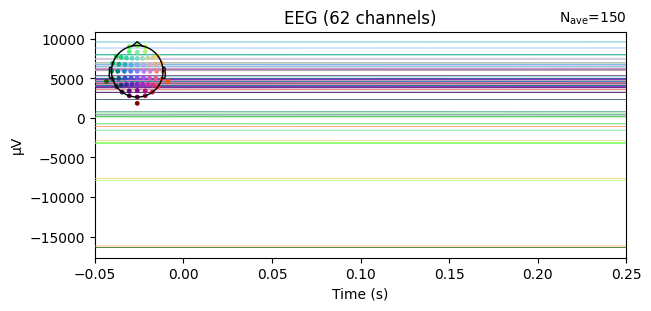

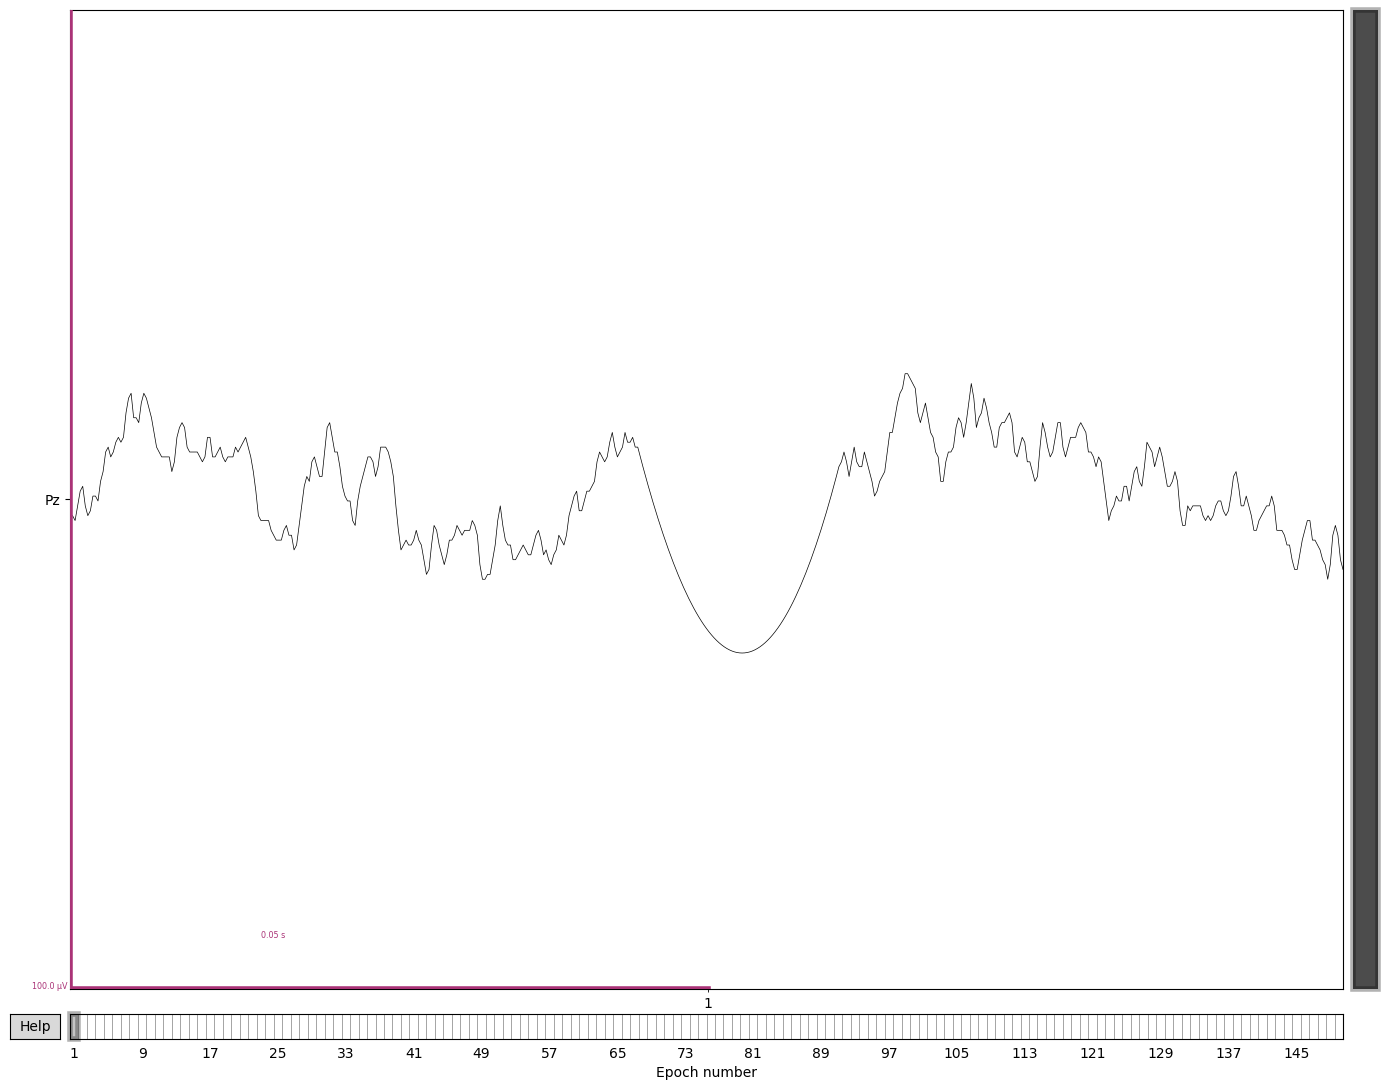

Downsampling...
Epoching...


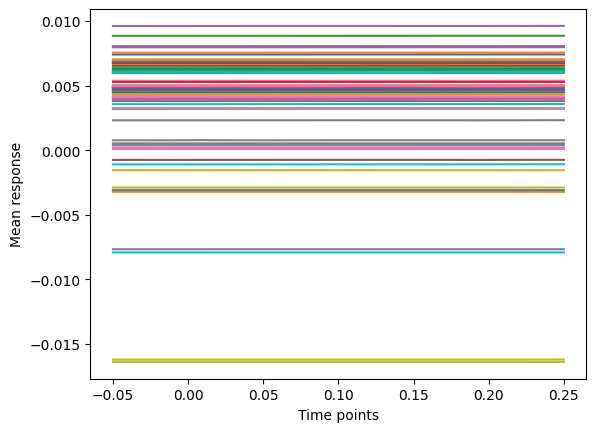

Demeaning...


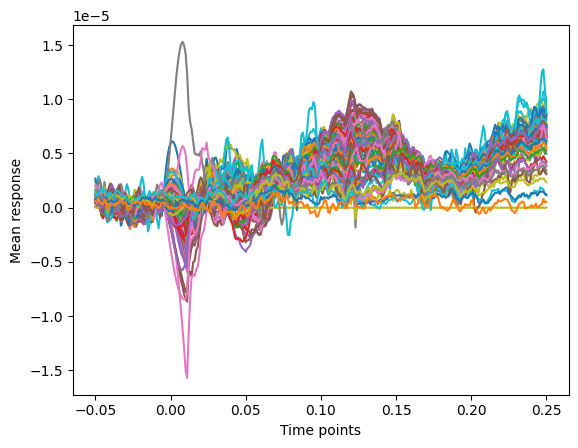

ICA 1...


d:\Coding\tms-research\spTEP_cleaning.py:122: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epoch_data)
d:\Coding\tms-research\spTEP_cleaning.py:126: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  averaged_sources = sources.get_data().mean(axis=0)


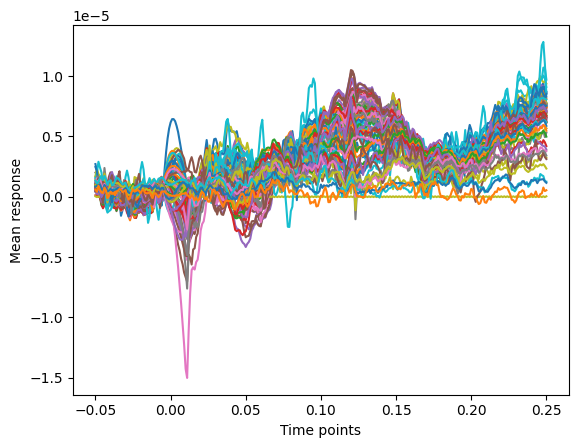

Bandpass & notch...


d:\Coding\tms-research\spTEP_cleaning.py:150: RuntimeWarning: filter_length (3301) is longer than the signal (2001), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_data.filter(low_freq, high_freq)
d:\Coding\tms-research\spTEP_cleaning.py:154: RuntimeWarning: filter_length (6601) is longer than the signal (2001), distortion is likely. Reduce filter length or filter a longer signal.
  notch_filtered = mne.filter.notch_filter(


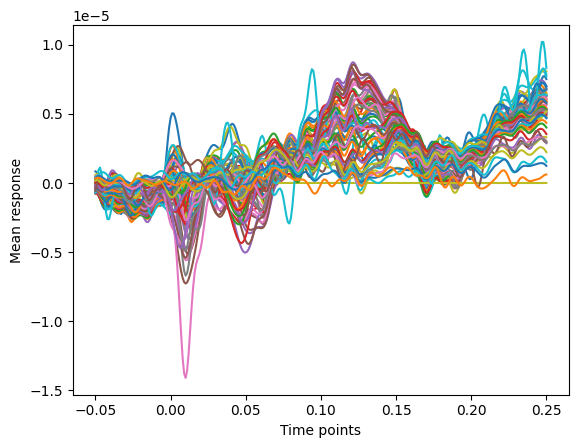

Rereference...


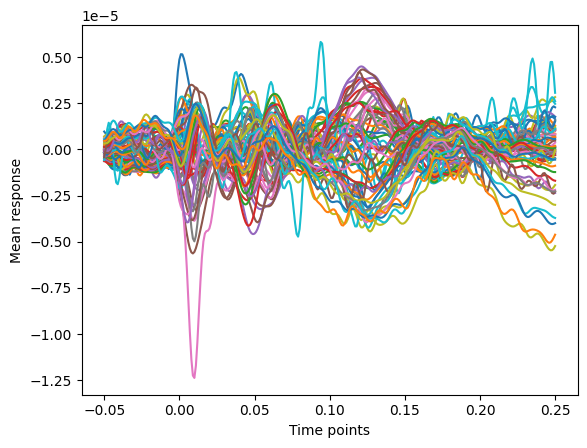

ICA 2...


d:\Coding\tms-research\spTEP_cleaning.py:170: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(epoch_data, ica, method="iclabel")


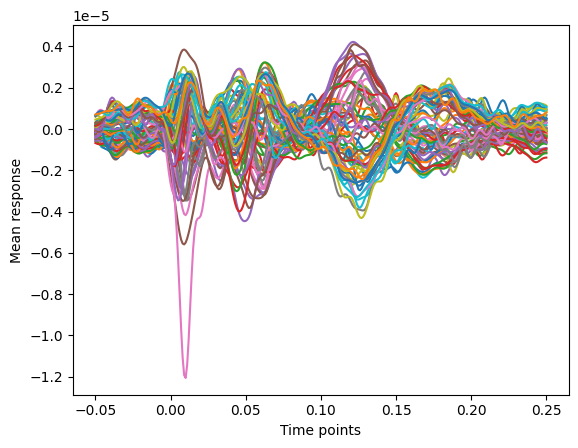

Baseline...


d:\Coding\tms-research\spTEP_cleaning.py:190: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs.pick_channels(electrodes)


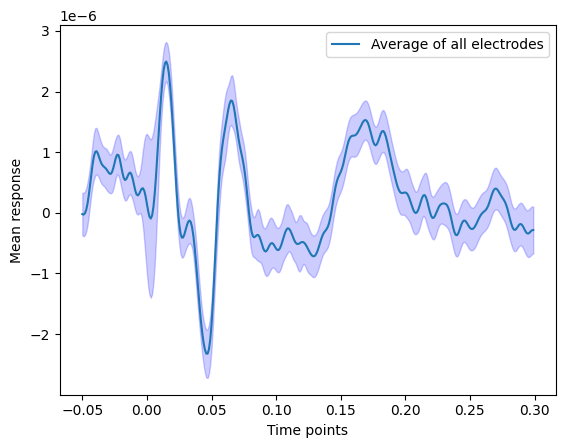

In [3]:
spTEP_cleaning.clean_spTEP(
    spTEP_filename,
    spTEP_pre_raw,
    plot_intermediate=True,
    plot_result=True,
    finalplot_electrodes=["F3", "FC5", "FC1"],
    finalplot_end=0.3,
)

In [ ]:
def process_file(file_path):
    raw = mne.io.read_raw_brainvision(file_path, preload=True)

    spTEP_cleaning.clean_spTEP(file_path, raw, plot_result=True, save_result=False)


DATASET_PATH = os.path.join(".", "dataset")

files = [
    os.path.join(DATASET_PATH, file)
    for file in os.listdir(DATASET_PATH)
    if file.endswith(".vhdr") and "spTEP" in file
]

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_file, file) for file in files]
    for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        pass

In [ ]:
# load fif file and apply plot_full_average_epoch on the epochs object
epochs = mne.read_epochs("filtered\TMS-EEG-H_02_S1b_spTEP_post_filtered-epo.fif")
spTEP_cleaning.plot_full_average_epoch(epochs)